# Описание данных и быстрый EDA

### Сущность данных
Port call –  операция в морской логистике, когда судно останавливается в определенном порту для выполнения различных необходимых действий, таких как погрузка или разгрузка груза, заправка топливом, смена экипажа и ремонт. Этот процесс включает в себя несколько этапов, в том числе прибытие, швартовку, грузовые операции и отбытие. В нашем случае доступны только данные по **прибытиям и отбытиям**

### Источник
API [myshiptracking.com](myshiptracking.com)

[Документация](https://api.myshiptracking.com/docs/port-calls)

Сотрудники сайта любезно дали мне бесплатные кредиты на использование их API специально для выполнения целей исследования

### Описание полей
- event – тип события (ARRIVAL/DEPARTURE)
- time_utc & time_local – таймстамп события
- mmsi & imo – идентификаторы судна
- vessel_name – название судна
- port_id & unloco – идентификаторы порта
- port_name – название порта

### Временной период
Данные доступны за весь 2024 


### *Вспомогательные данные
Отдельно собранная таблица с характеристиками судов, поля:
- vessel_name – название судна
- mmsi & imo – идентификатор судна 
- vessel_type – тип судна
- flag – флаг страны судна
- area – последняя зона нахождения судна

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
port_calls = pd.read_csv("data/ALL_ports.csv")
port_calls['time_utc'] = pd.to_datetime(port_calls['time_utc'])
port_calls['time_local'] = pd.to_datetime(port_calls['time_utc'])
port_calls.head()

,event,time_utc,time_local,mmsi,imo,vessel_name,port_id,port_name,unloco
0,ARRIVAL,2024-01-30 13:07:53+00:00,2024-01-30 13:07:53+00:00,253198000,NaN,AVISOA,6985,TOAMASINA,MGTOA
1,DEPARTURE,2024-01-30 10:51:18+00:00,2024-01-30 10:51:18+00:00,355280000,9747120.0,NORD OCEANIA,6985,TOAMASINA,MGTOA
2,DEPARTURE,2024-01-29 04:26:42+00:00,2024-01-29 04:26:42+00:00,354858000,9478793.0,KOUROS GLORY,6985,TOAMASINA,MGTOA
3,ARRIVAL,2024-01-29 02:22:21+00:00,2024-01-29 02:22:21+00:00,355280000,9747120.0,NORD OCEANIA,6985,TOAMASINA,MGTOA
4,DEPARTURE,2024-01-28 11:33:30+00:00,2024-01-28 11:33:30+00:00,565795000,9356830.0,KOTA NABIL,6985,TOAMASINA,MGTOA


In [27]:
print(f"Записей: {port_calls.shape[0]}")
print(f"Уникальных портов: {len(port_calls.port_name.unique())}")
print(f"Уникальных кораблей: {len(port_calls.mmsi.unique())}")

Записей: 143203
Уникальных портов: 28
Уникальных кораблей: 8741


In [28]:
port_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143203 entries, 0 to 143202
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   event        143203 non-null  object             
 1   time_utc     143203 non-null  datetime64[ns, UTC]
 2   time_local   143203 non-null  datetime64[ns, UTC]
 3   mmsi         143203 non-null  int64              
 4   imo          93601 non-null   float64            
 5   vessel_name  141826 non-null  object             
 6   port_id      143203 non-null  int64              
 7   port_name    143203 non-null  object             
 8   unloco       143203 non-null  object             
dtypes: datetime64[ns, UTC](2), float64(1), int64(2), object(4)
memory usage: 9.8+ MB


Много пропусков в IMO, будем использовать mmsi. У каких-то кораблей нет названия – дропнуть? Думаю, необязательно

In [29]:
port_calls.drop(columns=['imo'], inplace=True)   
# port_calls.dropna(subset=['port_name', 'mmsi'], inplace=True)

In [30]:
port_calls.mmsi.value_counts()

mmsi
634122000    3740
634123000    3676
375492000    2688
376913000    2108
375106000    1896
             ... 
403239110       1
352003762       1
576624000       1
352003644       1
312562000       1
Name: count, Length: 8741, dtype: int64

Немало кораблей, которые очень часто делают port calls. Скорее всего, это пассажирские судна. Стоит ли их оставлять?

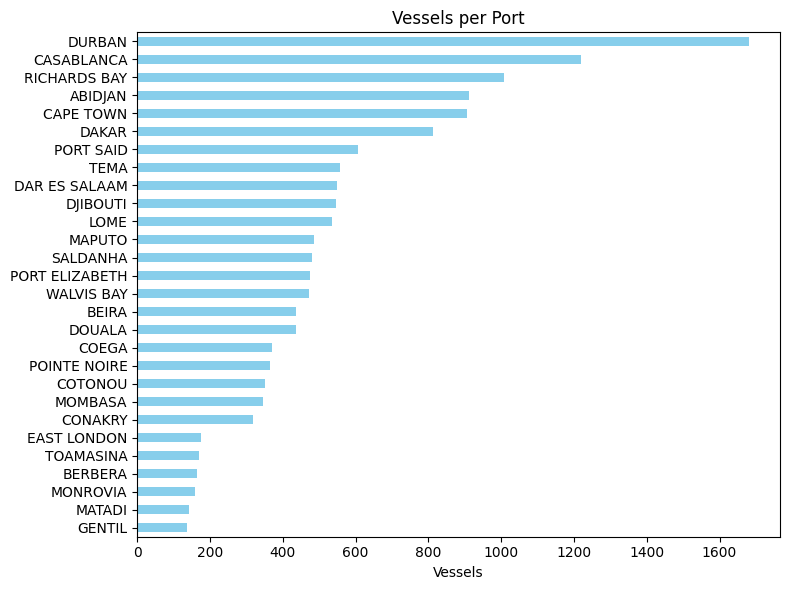

In [36]:
vessels_per_port = port_calls.groupby('port_name')['mmsi'].nunique()
vessels_per_port = vessels_per_port.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
vessels_per_port.plot(kind='barh', color='skyblue')
plt.title('Vessels per Port')
plt.xlabel('Vessels')
plt.ylabel('')
plt.tight_layout()
plt.show()

Распределение не выглядит слишком смещенным. Самый загруженный порт – Durban (South Africa). Из топ-5 портов 3 принадлежат ЮАР

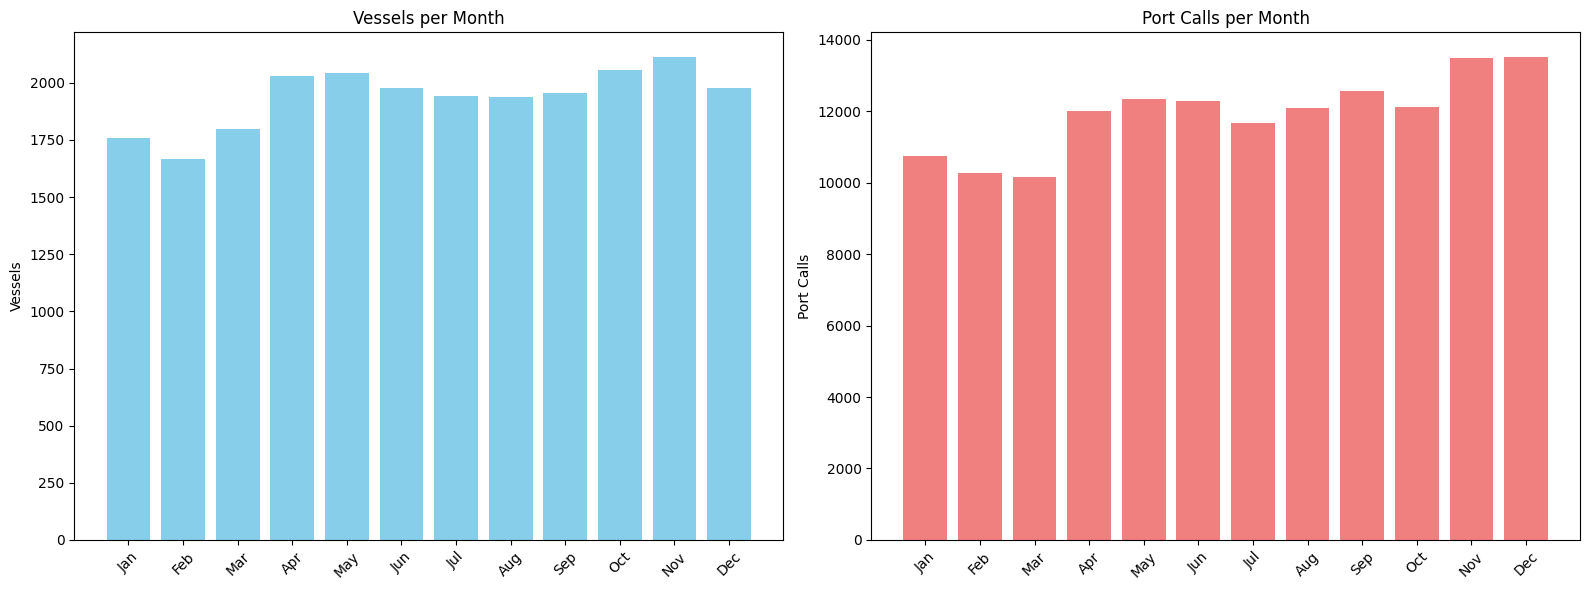

In [38]:
# Extract the month from the 'time_utc' column
port_calls['month'] = port_calls['time_utc'].dt.month

# Group by month and count unique vessels
vessels_per_month = port_calls.groupby('month')['mmsi'].nunique()

# Group by month and count total port calls
port_calls_per_month = port_calls.groupby('month').size()

# Create a grid of plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot the number of vessels per month
axes[0].bar(vessels_per_month.index, vessels_per_month.values, color='skyblue')
axes[0].set_title('Vessels per Month')
axes[0].set_xlabel('')
axes[0].set_ylabel('Vessels')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)

# Plot the number of port calls per month
axes[1].bar(port_calls_per_month.index, port_calls_per_month.values, color='lightcoral')
axes[1].set_title('Port Calls per Month')
axes[1].set_xlabel('')
axes[1].set_ylabel('Port Calls')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

Распределение кораблей и port calls по месяцам равномерное.

In [39]:
port_calls.event.value_counts()

event
DEPARTURE    72027
ARRIVAL      71176
Name: count, dtype: int64

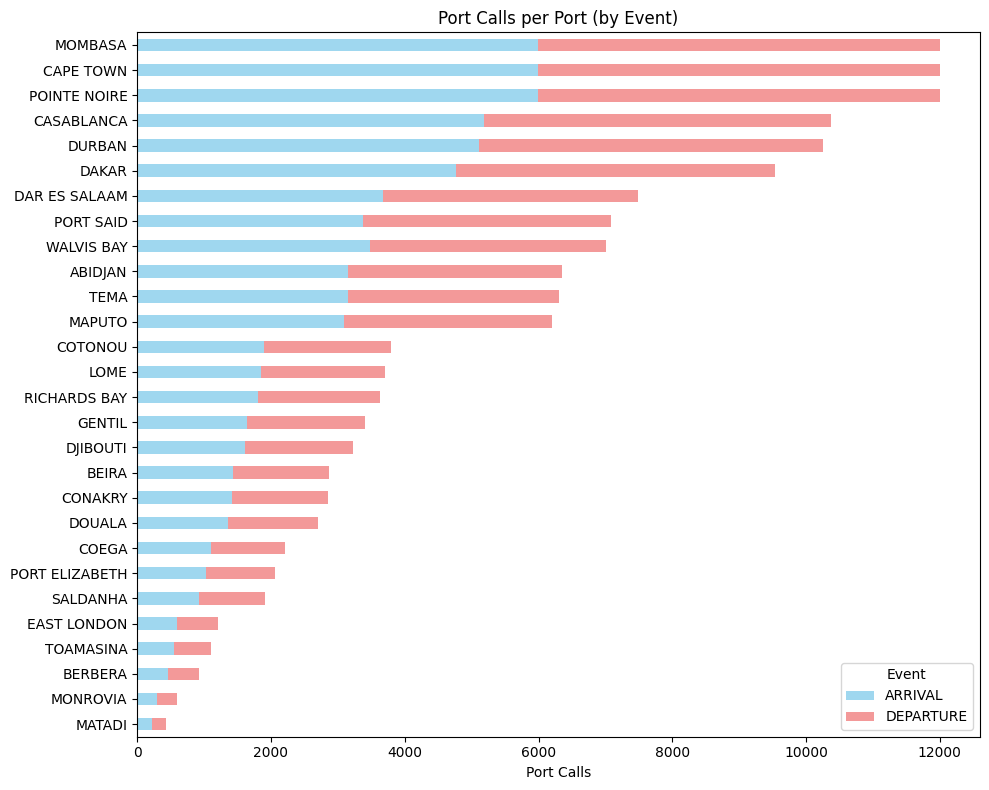

In [40]:
port_calls_by_event = port_calls.groupby(['port_name', 'event']).size().unstack(fill_value=0)

# Sort by the total number of port calls
port_calls_by_event = port_calls_by_event.loc[port_calls_by_event.sum(axis=1).sort_values(ascending=True).index]

# Plot the horizontal stacked bar chart
port_calls_by_event.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 8),
    color=['skyblue', 'lightcoral'],
    alpha=0.8
)

# Add chart details
plt.title('Port Calls per Port (by Event)')
plt.xlabel('Port Calls')
plt.ylabel('')
plt.legend(title='Event', loc='lower right')
plt.tight_layout()

# Show the plot
plt.show()

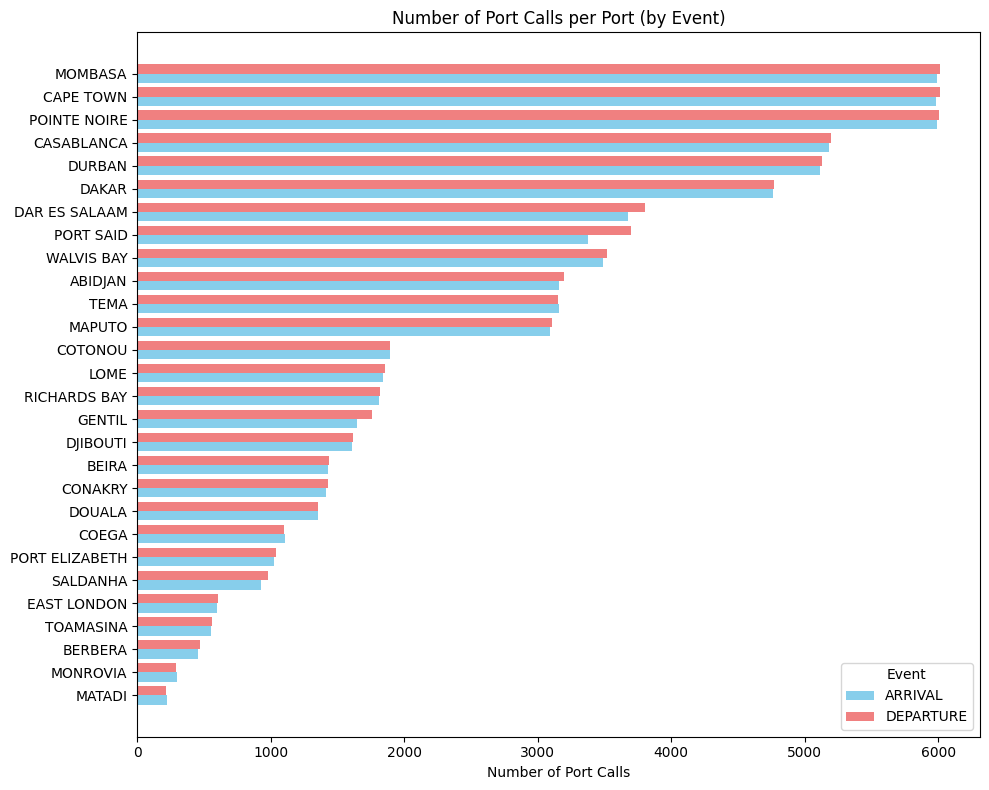

In [42]:
import numpy as np
# Group by port name and event type, then count the occurrences
port_calls_by_event = port_calls.groupby(['port_name', 'event']).size().unstack(fill_value=0)

# Sort by the total number of port calls
port_calls_by_event = port_calls_by_event.loc[port_calls_by_event.sum(axis=1).sort_values(ascending=True).index]

# Create the horizontal bar chart with bars next to each other
fig, ax = plt.subplots(figsize=(10, 8))
bar_width = 0.4  # Width of each bar
y_positions = np.arange(len(port_calls_by_event))  # Positions for the bars

# Plot bars for each event
ax.barh(y_positions - bar_width / 2, port_calls_by_event['ARRIVAL'], bar_width, label='ARRIVAL', color='skyblue')
ax.barh(y_positions + bar_width / 2, port_calls_by_event['DEPARTURE'], bar_width, label='DEPARTURE', color='lightcoral')

# Add labels and title
ax.set_yticks(y_positions)
ax.set_yticklabels(port_calls_by_event.index)
ax.set_xlabel('Number of Port Calls')
ax.set_title('Number of Port Calls per Port (by Event)')
ax.legend(title='Event')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()